A jupyter notebook that shows some examples of how to read in and use data from COMPAS simulations when using ***STROOPWAFEL*** (or Adaptive Importance Sampling: AIS)

Last updated by: Floor Broekgaarden 9 March 2019
Email: fsbroekgaarden@gmail.com

#  0. Download data from tsunami to local computer: 

<div class="alert alert-block alert-info"> 


After the runs your data should be in two files on tsunami:  <br>
**AIS_exploratory** <br> 
**AIS_sampling** <br> 

## 0.1 make sure your COMPASOutput.h5 contains the weight files. 

<div class="alert alert-block alert-info"> 

in the current version of COMPAS you have to resubmit postProcessing in all the STROOPWAFEL data folders, to attach the `allDoubleCompactObjectsWeights.txt` and `allSystemsWeights.txt` to the `COMPASOutput.h5`

To check this you can in tsunami in your `AIS_exploratory` or `AIS_sampling` directory start python and run the following: 


In [3]:
import os, sys, argparse
import h5py
from numpy import array
import h5py as h5
f = h5.File('COMPASOutput.h5') 
# if you are not in your data directory do:
#f =  h5.File( '/Volumes/TOSHIBA EXT/Stroopwafel2_0/BNS/AIS_sampling/' +'COMPASOutput.h5') 
print(list(f.keys()))

['XRayBinaries', 'commonEnvelopes', 'cppSource', 'doubleCompactObjects', 'doubleCompactObjectsWeights', 'formationChannels', 'pulsarEvolution', 'runtimes', 'supernovae', 'systems', 'systemsWeights']


<div class="alert alert-block alert-info"> 

If the keys `systemsWeights` and `doubleCompactObjectWeights` are shown, everything works. <br>

otherwise you need to resubmit once the postProcessing in all your data directories by doing: <br>
    
    
(in the future this will be done automatically) 




## 0.2 copy COMPASOutput.h5 to local directory

now copy your data to a local directory so we can run the data analysis. 
The only file that you need to copy from the tsunami directory is the `COMPASOutput.h5` since this now contains also the weights

Say you want to name your directory `'BNS'` then make two subdirectories in this:
```mkdir BNS/AIS_exploratory```
```mkdir BNS/AIS_sampling``` 

and copy the corresponding COMPASOutput.h5 files to your local directories 

```scp -r path/tsunami/to/BNS/AIS_exploratory/COMPASOutput.h5 path/local/to/BNS/AIS_exploratory/.``` <br>

```scp -r path/tsunami/to/BNS/AIS_sampling/COMPASOutput.h5 path/local/to/BNS/AIS_sampling/.```

You should end up with 2 subdirectories both containing COMPASOutput.h5 files: 
    
> BNS/AIS_exploratory/COMPASOutput.h5 <br>
> BNS/AIS_sampling/COMPASOutput.h5

# 1. Analyze data 

The remaining notebook will demonstrate how to use the python funtions below to read in the data and use the weights to obtain the same graphs or results as you would get with normal Monte Carlo sampled simulation run

In [4]:
from __future__ import division # in case you are using python 2
import h5py as h5 # hdf5 file library

%matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt

# Plotting settings:
import matplotlib
from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams
rc('font', family='serif')

matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
fs = 30   #  fontsize in plots 

In [5]:

def obtainDataSTROOPWAFEL(param, pathToDirectory):
    """returns for STROOPWAFEL (AIS) simulation the data of wanted variable
    combines the data from AIS_exploratory and AIS_sampling 
    
    param = [xparam, fxparam] ,  are the name of the variable and hdf5 keyname where it is in
    e.g. param = ['M1', 'doubleCompactObjects'] (see also: print(list(f.keys())))
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """ 

    xparam, fxparam = param

    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'  
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    

    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref)
      
        
    ##### get parameter from two directories and combine them ############
    xvaluesAISexpl          = fAISexpl[fxparam][xparam][...].squeeze()
    xvaluesAISref           = fAISref[fxparam][xparam][...].squeeze()

    xvalues = np.concatenate((xvaluesAISexpl, xvaluesAISref))

    return   xvalues



def maskTargetDCOsSTROOPWAFEL(fxparam, DCOtype, boolDCOmask, pathToDirectory):
    """returns mask of DCOs of interest
    fxparam  is hdf5 keyname of file where variable for which you want to mask DCOs is in 
    DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """
    
    Hubble, RLOF, Pessimistic = boolDCOmask
    
    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'   
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    
    
    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref) 
    
    fDCOAISexpl = fAISexpl['doubleCompactObjects']
    fDCOAISref  = fAISref['doubleCompactObjects']
    
    
    
    # mask binaries of given DCO type
    if DCOtype == 'BNS':
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 13) & (fDCOAISexpl['stellarType2'][...] == 13))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 13) & (fDCOAISref['stellarType2'][...] == 13))

    elif (DCOtype == 'BHNS') | (DCOtype == 'NSBH'):
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 13) & (fDCOAISexpl['stellarType2'][...] == 14)) | \
            ((fDCOAISexpl['stellarType1'][...] == 14) & (fDCOAISexpl['stellarType2'][...] == 13) )          
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 13) & (fDCOAISref['stellarType2'][...] == 14)) | \
            ((fDCOAISref['stellarType1'][...] == 14) & (fDCOAISref['stellarType2'][...] == 13) )
    elif DCOtype == 'BBH':
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 14) & (fDCOAISexpl['stellarType2'][...] == 14))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 14) & (fDCOAISref['stellarType2'][...] == 14))

    elif (DCOtype == 'all') | (DCOtype == 'ALL') :
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 14) | (fDCOAISexpl['stellarType1'][...] == 13))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 14) | (fDCOAISref['stellarType1'][...] == 13))
    else:
        print('error: DCO type not known')
        
    # Hubble mask
    if Hubble:
        mask1AISexpl = (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==True) 
        mask1AISref = (fDCOAISref['mergesInHubbleTimeFlag'][...]==True) 
    elif not Hubble:
        mask1AISexpl = (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==True) |  (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==False) 
        mask1AISref = (fDCOAISref['mergesInHubbleTimeFlag'][...]==True) |  (fDCOAISref['mergesInHubbleTimeFlag'][...]==False) 
       
    # RLOF mask
    if RLOF:
        mask2AISexpl = (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==False)
        mask2AISref = (fDCOAISref['RLOFSecondaryAfterCEE'][...]==False)
    elif not RLOF:
        mask2AISexpl = (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==False) | (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==True)
        mask2AISref = (fDCOAISref['RLOFSecondaryAfterCEE'][...]==False) |  (fDCOAISref['RLOFSecondaryAfterCEE'][...]==True)

    # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
    if Pessimistic:
        mask3AISexpl = np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 1)
        mask3AISref  = np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 1)
    elif not Pessimistic:
        mask3AISexpl = np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 1) + \
        np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 0)   
        mask3AISref = np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 1) + \
        np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 0) 
    
    # combine the different masks and the exploratory and refinement masks
    combinedMaskAISexpl = mask0AISexpl * mask1AISexpl * mask2AISexpl * mask3AISexpl
    combinedMaskAISref = mask0AISref * mask1AISref * mask2AISref * mask3AISref  
    combinedmask = np.concatenate((combinedMaskAISexpl, combinedMaskAISref))

    if fxparam != 'doubleCompactObjects': # we need to get the mask from comparing the seeds
        
        # you might need to change 'randomSeed if that's not the name of the seed param in the file
        seedsOfIntererstAISexpl = fDCOAISexpl['seed'][combinedMaskAISexpl]
        seedsAISexpl = fAISexpl[fxparam]['randomSeed'][...].squeeze()
        boolsAISexpl = np.in1d(seedsAISexpl, seedsOfIntererstAISexpl)
       
        seedsOfIntererstAISref = fDCOAISref['seed'][combinedMaskAISref]
        seedsAISref = fAISref[fxparam]['randomSeed'][...].squeeze()
        boolsAISref = np.in1d(seedsAISref, seedsOfIntererstAISref)      
    
        combinedmask = np.concatenate((boolsAISexpl, boolsAISref))
          
    return combinedmask.squeeze()


def obtainWeightsSTROOPWAFEL(pathToDirectory):
    """returns weights for all DCOs and all systems for STROOPWAFEL
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are 
    """
    
    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'   # '/home/floor/Data_Thesis/bdMC/Z0_002'
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    # '/home/floor/Data_Thesis/bdMC/Z0_002'

    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref)    


    ##### get the DCO and all system weights  ############
    DCOweightsAISexpl          = fAISexpl['doubleCompactObjectsWeights']['weight'][...].squeeze()
    DCOweightsAISref           = fAISref['doubleCompactObjectsWeights']['weight'][...].squeeze()
    
    DCOweights = np.concatenate((DCOweightsAISexpl, DCOweightsAISref))
    
    systemsweightsAISexpl          = fAISexpl['systemsWeights']['weight'][...].squeeze()
    systemsweightsAISref           = fAISref['systemsWeights']['weight'][...].squeeze()    
    
    systemsweights = np.concatenate((systemsweightsAISexpl, systemsweightsAISref))
    
    
    return DCOweights, systemsweights




In [6]:
def plotweightedhistogram(var, weights, varlabel, title):
    '''plot weighted histogram of given variable'''
    
    f, ax = plt.subplots(1, 1,  figsize=(10,10)) 
    
    ax.hist(var, 30, lw = 3, histtype = 'stepfilled', weights = weights)
    ax.set_xlabel(varlabel[0] , fontsize = fs)
    ax.set_ylabel(varlabel[1] , fontsize = fs)
    ax.set_title(title, fontsize = fs)
    ax.grid(True)
    ax.tick_params(labelsize=fs)
    
    return ax



In [7]:
def plothistogram(var,  varlabel, title):
    '''plot histogram of given variable'''
    
    f, ax = plt.subplots(1, 1,  figsize=(10,10)) 
    
    ax.hist(var, 30, lw = 3, histtype = 'stepfilled')
    ax.set_xlabel(varlabel[0] , fontsize = fs)
    ax.set_ylabel(varlabel[1] , fontsize = fs)
    ax.set_title(title, fontsize = fs)
    ax.grid(True)
    ax.tick_params(labelsize=fs)
    
    return ax



# EXAMPLES of distribution plots

In [8]:
# say your data lives here (this should be the location of the AIS_sampling and AIS_exploratory: 

myPathToBNS = '/Volumes/TOSHIBA EXT/Stroopwafel2_0/BNS/'



# 1a:    Plot histogram of all primary NS masses of NS-NS mergers in a Hubble time:

<div class="alert alert-block alert-info"> 

Since we didn't distribute the samples in the simulation folliwing the birth distributions (e.g. IMF), we have to use the weights to correct the probability of occurance for each binary
This can be simply done by including the weights in a histogram. Instead of counting the nr of binaries to get your rates or number, you now have to sum up the weights.  <br>

This will give you the same results / plots as when you would have used traditional monte carlo sampling, but now with much higher precision / resolution. <br> 

Say we want to plot the distribution of the NS masses of our first formed neutron stars. By setting in the `plt.histogram()` `weights = our_weights` we obtain the right plot. 





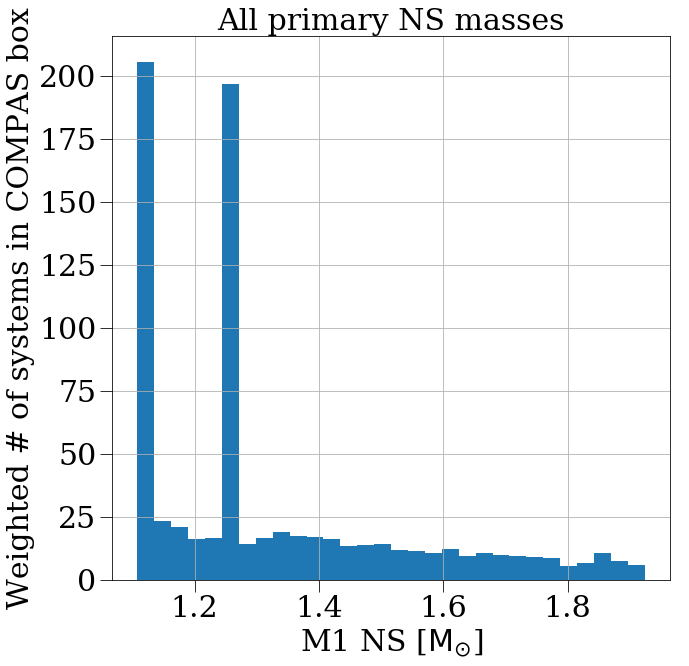

In [9]:

# we want the neutron star masses: M1, which is a parameter that is given in 'doubleCompactObjects'
fDCO = 'doubleCompactObjects'
#get data:
M1 = obtainDataSTROOPWAFEL(param = ['M1', fDCO ], pathToDirectory = myPathToBNS)
#obtain weights:
weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)
# now mask BNS that merge in a Hubble time, that don't have RLOFafterCE and optimistic, i.e. boolDCOmask = [1,1,0]
BNSmask = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = 'BNS', \
                                boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)

# use the mask to obtain the data and weight of only the binaries of interest 
M1BNS, weightsBNS = M1[BNSmask], weightsDCO[BNSmask]

# plot the distribution :
plotweightedhistogram(M1BNS, weights = weightsBNS, \
    varlabel = [r'M1 NS [$\rm{M}_{\odot}$]', r'Weighted # of systems in COMPAS box'], title = 'All primary NS masses')


<div class="alert alert-block alert-info"> 

We recovered the primary neutron star mass distribution. I called the y-axes here "weighted # of systems in COMPAS box" <br>. With this I mean that in your COMPAS box (given by which values you assume for the initial mass, mass ratio and separation range) the number of events when you would have sampled from the birth distribution is equal to this weighted number. In other words in a traditional simulation you would in this case have found ~200 BNS mergers with 1.1 Msun solar masses (first peak) out of  1E6 sampled binaries. (in my simulation I used a total of ~ 1E6 samples) <br> 

However, the total number of binaries that I found with STROOPWAFEL is much higher, namely: 






In [10]:
print('the number of BNS mergers in a Hubble time found with STROOPWAFEL is', len(M1BNS))
print('and their combined weight = ', np.sum(weightsBNS))

the number of BNS mergers in a Hubble time found with STROOPWAFEL is 21294
and their combined weight =  760.8327377674943


<div class="alert alert-block alert-info"> 

and this is key. So if you would have run a traditional Monte Carlo simulation with COMPAS with 1E6 binaries I would have found ~761 binaries (total sum of the weights) 
whereas now, by sampling smarter I find ~ 21300 binaries. 
And by using the weights, I can scale back the information to the traditional simulation :-) 







# 1b:    Plot histogram of all initial masses of all DCO merges (BH-BH, BH-NS and NS-NS) (in and not in a Hubble time):


even if your simulation was focused on BNS mergers, you can still get the information of other DCOs such as ALL mergers: 

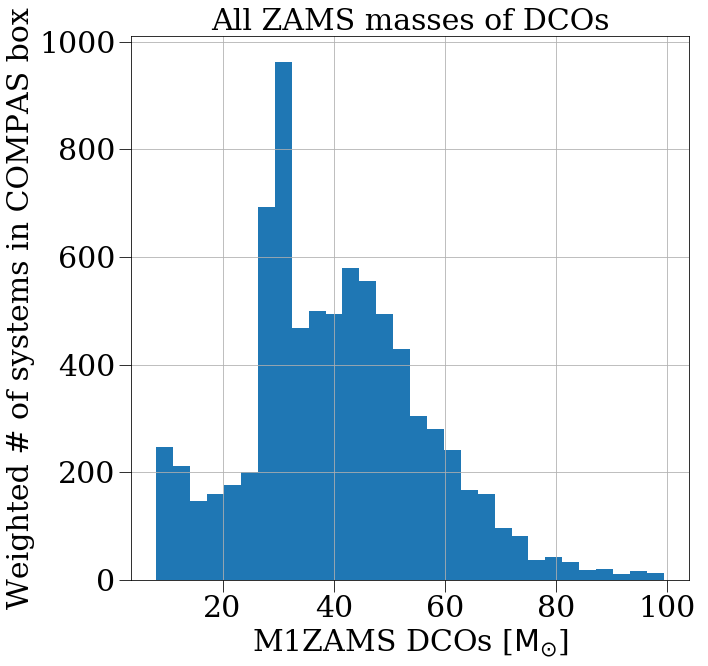

In [11]:

fDCO = 'doubleCompactObjects'

M1ZAMS = obtainDataSTROOPWAFEL(param = ['M1ZAMS', fDCO ], pathToDirectory = myPathToBNS)
M2ZAMS = obtainDataSTROOPWAFEL(param = ['M2ZAMS', fDCO ], pathToDirectory = myPathToBNS)
weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)

ALLmask = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = 'all', \
                                boolDCOmask = [1,0,0], pathToDirectory = myPathToBNS)

M1ZAMS, weights = M1ZAMS[ALLmask], weightsDCO[ALLmask]


plotweightedhistogram(M1ZAMS, weights = weights, \
    varlabel = [r'M1ZAMS DCOs [$\rm{M}_{\odot}$]', r'Weighted # of systems in COMPAS box'], title = 'All ZAMS masses of DCOs')




# 1c:    Plot histogram of all initial masses of all binaries 





similar you can also use the weights of all systems to plot the properties of all initial binaries that you sampled. 

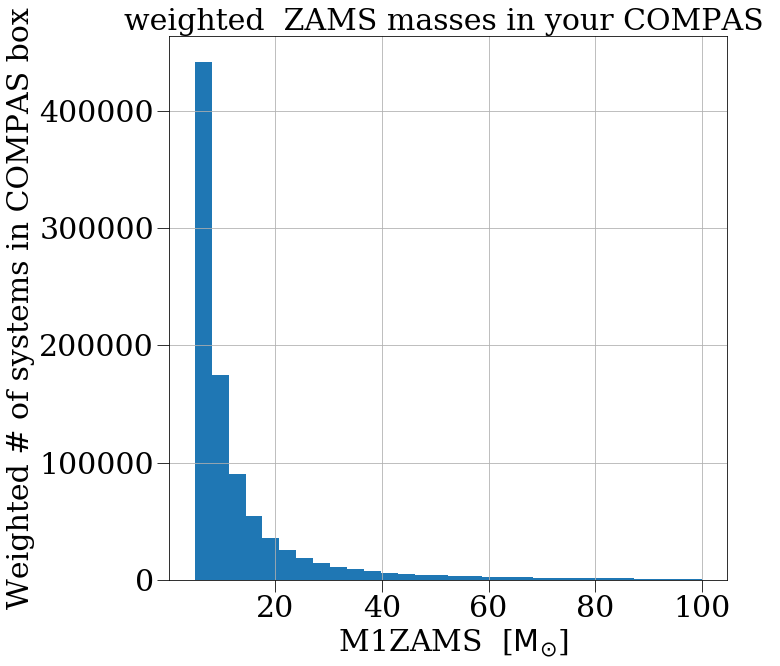

In [12]:

fDCO = 'systems'

mass1 = obtainDataSTROOPWAFEL(param = ['mass1', fDCO ], pathToDirectory = myPathToBNS)
weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)

plotweightedhistogram(mass1, weights = weightsAllSystems, \
    varlabel = [r' M1ZAMS  [$\rm{M}_{\odot}$]', r'Weighted # of systems in COMPAS box'],\
                      title = 'weighted  ZAMS masses in your COMPAS ')




If you use the weighted histogram, this will recover the IMF. Since the fact that we sampled from a different distribution is corrected with the weights <br>

However, you can plot an unweighted histogram to see what the distribution of samples is that we drew in COMPAS.(see next plot). You can see in the Figure below that compared to the distribution above, more massive binaries are sampled that lie in the region that becomes a NS.  


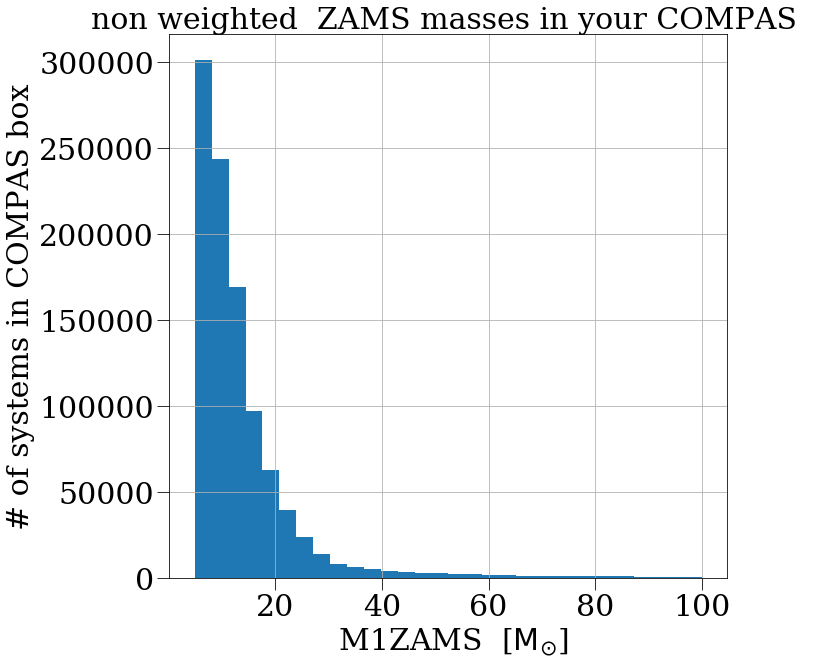

In [13]:


plothistogram(mass1, varlabel = [r' M1ZAMS  [$\rm{M}_{\odot}$]', r'# of systems in COMPAS box'],\
                      title = 'non weighted  ZAMS masses in your COMPAS ')





# 1d:    Plot histogram of  SNe properties:




If we want to look at the `supernovae` properties, we have to take one more step, since the nr of systems in the supernovae file does not (always) correspond with the nr of systems in the doubleCompactObjects file
the same would be the case for the `Common Envelopes` file or the `RLOF` file

In order to deal with this we create 2 masks, a SN mask, which uses the bools and seeds of the parameters (see the mask function)
and then the double compact objects mask for the `weights` (which have the same length as the `doublecompactobjects` file). 
this is why we have to call the function `maskTargetDCOsSTROOPWAFEL` twice

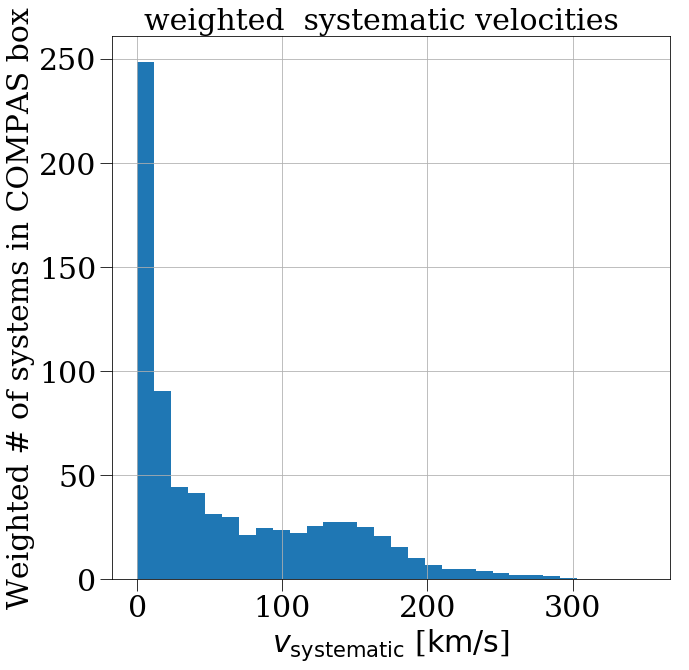

In [14]:

fSN = 'supernovae'
fDCO = 'doubleCompactObjects'

# obtain e.g. systematic Velocities which is a parameter in supernovae 
systematicVelocity = obtainDataSTROOPWAFEL(param = ['systemicVelocity', fSN ], pathToDirectory = myPathToBNS)
weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)

# create a mask for the SN properties. this is done by matching the seeds (see function)
BNSmaskSN = maskTargetDCOsSTROOPWAFEL(fxparam = fSN,  DCOtype = 'BNS', \
                                boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)
# create a seperate mask for the weights 
BNSmaskDCO = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = 'BNS', \
                                boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)
# mask the parameters
systematicVelocity = systematicVelocity[BNSmaskSN]
weights =  weightsDCO[BNSmaskDCO]

#take only the first SN 1: 
systematicVelocitySN1 = systematicVelocity[::2]

# plot 
plotweightedhistogram(systematicVelocitySN1, weights = weights, \
    varlabel = [r'$ v_{\rm{systematic}} $ [$\rm{km/s}$]', r'Weighted # of systems in COMPAS box'],\
                      title = 'weighted  systematic velocities  ')



# note that the weights are per binary, so the weights for SN2 are the same as for SN 1
# as long as they correspond to the same binary:-) 

# 2 Calculating merger rates 

To calculate the physical rate of your merger events consist of 2 steps:

-  calculate the "equivalent" mass that your COMPAS simulation represents (i.e. if we would have included all binaries instead of the cut-offs that we took for example by only simulating binaries with stars with masses > 5 Msun) 
-  use the Star formation rate to translate this into a rate per time. 

For the equivalent mass calculation, it is easy to run a small Monte Carlo simulation.
In this Monte Carlo simulation you draw a large sample of binaries from the full initial mass, mass ratio and seperation distribution (so including all stars also low mass stars). This population then represents what in a  galaxy the distribution of stars would be. By then selecting the systems that you include in your COMPAS box simulation (where you e.g. only consider high mass stars), you can calculate the mass fraction between the 2 simulations to figure out how much mass on average simulating one binary system in your COMPAS box would represent.





In [16]:

# initial disributions of binaries in the Universe

def sampling_from_IMF(Nsamples): 
    """returns Nsamples distributed according to the IMF """

    kroupaPower1 = -0.3
    kroupaPower2 = -1.3
    kroupaPower3 = -2.3

    # // Often require the np.powerer law exponent plus one
    kroupaPowerPlus1_1 = 0.7
    kroupaPowerPlus1_2 = -0.3
    kroupaPowerPlus1_3 = -1.3

    # // There are two breaks in the Kroupa np.powerer law -- they occure here (in solar masses)
    kroupaBreak1 = 0.08     
    kroupaBreak2 = 0.5
    #  C is the normalisation constant for the integral of the IMF over the desired range
    C = 0.0# 
    # will hold a uniform random number U(0,1)
    u = 0.0


    initialMassFunctionMin = 0.08
    initialMassFunctionMax = 150	

    firstBrackets = (1.0/kroupaPowerPlus1_2)*(np.power(kroupaBreak2, kroupaPowerPlus1_2) - np.power(initialMassFunctionMin, kroupaPowerPlus1_2))
    secondBrackets = (1.0/kroupaPowerPlus1_3)*(np.power(initialMassFunctionMax, kroupaPowerPlus1_3) - np.power(kroupaBreak2, kroupaPowerPlus1_3))

    C = firstBrackets + secondBrackets

    u =  np.random.uniform(0,1,Nsamples)             #// Draw a random number between 0 and 1

    thisMass = np.zeros_like(u)

    mask1 = (u < firstBrackets/C)
    mask2 = (u >= firstBrackets/C)
    thisMass[mask1] = np.power(((C * u[mask1] * kroupaPowerPlus1_2) + np.power(initialMassFunctionMin, kroupaPowerPlus1_2)), (1.0/kroupaPowerPlus1_2))
    thisMass[mask2] = np.power(((((C * u[mask2]) - firstBrackets)*kroupaPowerPlus1_3) + np.power(kroupaBreak2, kroupaPowerPlus1_3)), (1.0/kroupaPowerPlus1_3))

    return thisMass


def sampling_from_q(Nsamples):
    '''returns  N samples distributed uniformly from q '''
    
    # Full range of mass ratio q:
    [a_q, b_q] = [0,1]
    
    return np.random.uniform(a_q, b_q, Nsamples)



In [17]:



def ObtainEquivalentMassCOMPASsimulation(COMPASbox, Nbinaries, NsamplesMCres):
    '''Runs a  MC simulation to determine what the mass fraction is  in your COMPAS simulation
       compared to what it would be equivalent to if you would have included the entire parameter range
       so for example if you would have included low mass stars as well 
       assumes binary fraction f = 1
       
       Nbinaries = 1E6, number of binary systems used in your simulation 
       NsamplesMCres = 1E8 # number of binaries drawn for Monte Carlo simulation, determines resolution
       COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1] = m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2
       '''
    
    m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2 = COMPASbox 

    # obtain large MC sample for m1 and m2 (masses binary) 
    m1s = sampling_from_IMF(NsamplesMCres) 
    qs = sampling_from_q(NsamplesMCres)
    m2s =  qs * m1s 
    
    # now mask binaries in the COMPAS box. 
    maskCOMPASm = ((m1s >= m1_min) & (m1s <=m1_max) &   (m2s >= min_m2))  
    
    fractionSamplesInCOMPAS = np.sum(maskCOMPASm) / len(maskCOMPASm)
    
    #  calculate the mass from the Monte Carlo simulation that belongs to the COMPAS box 
    TotalMassCOMPAS = np.sum(m1s[maskCOMPASm]) + np.sum(m2s[maskCOMPASm])
    # calculate the entire mass in the Monte Carlo simulation.
    TotalMassALL =  np.sum(m1s) + np.sum(m2s)
    # The fraction of mass of COMPAS to all mass from the entire parameter space is:
    fractionTotalMassCOMPAS = TotalMassCOMPAS / TotalMassALL
    

    meanMassBinaryCOMPAS = (TotalMassCOMPAS / np.sum(maskCOMPASm))  # average mass per system in a COMPAS box
    meanMassBinaryEquivalentCOMPAS = meanMassBinaryCOMPAS / fractionTotalMassCOMPAS  # average equivalent mass per system from COMPAS box (in reality 1 system also represents smaller mass systems)


    EquivalentSimulatedMassCOMPAS = meanMassBinaryEquivalentCOMPAS * Nbinaries # now times the number of binaries that was simulated
    
    return EquivalentSimulatedMassCOMPAS
    
    
   
    

In [18]:

# give parameter range of COMPAS box. 
COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1]  #     m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2 [parameter box values / limits]


# obtain the nr of systems that you simulated
fDCO = 'systems'
mass1 = obtainDataSTROOPWAFEL(param = ['mass1', fDCO ], pathToDirectory = myPathToBNS)
print('total number of binaries sampled in simulation = ' , len(mass1))

Nbin = len(mass1)

EquivalentMassCOMPAS = ObtainEquivalentMassCOMPASsimulation(COMPASbox = COMPASbox, Nbinaries = Nbin \
                                                            , NsamplesMCres = int(1E8))

print('your equivalent mass simulated with COMPAS equals = ', EquivalentMassCOMPAS, 'Msun')

# note that this is the same as in a traditional COMPAS run with the same parameter boundries. 
# Does not change when using STROOPWAFEL

total number of binaries sampled in simulation =  1000019
your equivalent mass simulated with COMPAS equals =  64631941.120961554 Msun


In [19]:
SFR = 2.0*10**6 # [SFR] = Msol Myr^-1 # The continuous star formation rate \
# assumed in a Milky Way like Galaxy (see e.g. Dominik 2012 or de Mink & Belczynski for reference)  

#get Compact object parameter to get rate:
fDCO = 'doubleCompactObjects'
M1 = obtainDataSTROOPWAFEL(param = ['M1', fDCO ], pathToDirectory = myPathToBNS)
#obtain weights:
weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)
# now mask BNS that merge in a Hubble time, that don't have RLOFafterCE and optimistic, i.e. boolDCOmask = [1,1,0]
BNSmask = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = 'BNS', \
                                boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)

# use the mask to obtain the data and weight of only the binaries of interest 
M1BNS, weightsBNS = M1[BNSmask], weightsDCO[BNSmask]


COMPASweight = np.sum(weightsBNS)
print('rate in COMPAS box = ', COMPASweight, 'out of ', Nbin, 'binaries (weighted to traditionally)')
COMPASrate = COMPASweight / Nbin # rate in traditional COMPAS box

Galaxyrate = (COMPASweight / EquivalentMassCOMPAS ) *SFR 
print('BNS merger rate = ', Galaxyrate ,'mergers per Myr per MWEG (milky way equivalent galaxy)')




rate in COMPAS box =  760.8327377674943 out of  1000019 binaries (weighted to traditionally)
BNS merger rate =  23.54355213758974 mergers per Myr per MWEG (milky way equivalent galaxy)


or here's a way to do it all in one function: 

In [20]:
def calculateMergerRate(COMPASbox, DCOtype, boolDCOmask, pathToDirectory):
    """
    returns physical merger rate of wanted DCO type in your simualtion 
    
    COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1]
    DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """
    
    #Constant:
    SFR = 2.0*10**6 # [SFR] = Msol Myr^-1 # The continuous star formation rate \
    # assumed in a Milky Way like Galaxy (see e.g. Dominik 2012 or de Mink & Belczynski for reference)  

    
    
    # give parameter range of COMPAS box. 
      #     m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2 [parameter box values / limits]


    # obtain the nr of systems that you simulated
    fDCO = 'systems'
    mass1 = obtainDataSTROOPWAFEL(param = ['mass1', fDCO ], pathToDirectory = pathToDirectory)
    print('total number of binaries sampled in simulation = ' , len(mass1))

    Nbin = len(mass1)

    EquivalentMassCOMPAS = ObtainEquivalentMassCOMPASsimulation(COMPASbox = COMPASbox, Nbinaries = Nbin \
                                                                , NsamplesMCres = int(1E8))

    print('your equivalent mass simulated with COMPAS equals = ', EquivalentMassCOMPAS, 'Msun')

    # note that this is the same as in a traditional COMPAS run with the same parameter boundries. 
    # Does not change when using STROOPWAFEL    


    
    #get Compact object parameter to get rate:
    fDCO = 'doubleCompactObjects'
    M1 = obtainDataSTROOPWAFEL(param = ['M1', fDCO ], pathToDirectory = myPathToBNS)
    #obtain weights:
    weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = myPathToBNS)
    # now mask BNS that merge in a Hubble time, that don't have RLOFafterCE and optimistic, i.e. boolDCOmask = [1,1,0]
    BNSmask = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = 'BNS', \
                                    boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)

    # use the mask to obtain the data and weight of only the binaries of interest 
    M1BNS, weightsBNS = M1[BNSmask], weightsDCO[BNSmask]


    COMPASweight = np.sum(weightsBNS)
    print('rate in COMPAS box = ', COMPASweight, 'out of ', Nbin, 'binaries (weighted to traditionally)')
    COMPASrate = COMPASweight / Nbin # rate in traditional COMPAS box

    Galaxyrate = (COMPASweight / EquivalentMassCOMPAS ) *SFR 
    print('BNS merger rate = ', Galaxyrate ,'mergers per Myr per MWEG (milky way equivalent galaxy)')

    return Galaxyrate




In [21]:
rateBNS =  calculateMergerRate(COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1], \
                               DCOtype = 'BNS', boolDCOmask = [1,1,0], pathToDirectory = myPathToBNS)

total number of binaries sampled in simulation =  1000019
your equivalent mass simulated with COMPAS equals =  64700278.14628779 Msun
rate in COMPAS box =  760.8327377674943 out of  1000019 binaries (weighted to traditionally)
BNS merger rate =  23.51868522256569 mergers per Myr per MWEG (milky way equivalent galaxy)


In [ ]:
# multiply by 10 to get LIGO equivalent merger rates (in Gpc^-3 etc. MWEG^-1 yr  )